In [1]:
import sys
code_path = "/mnt/code/users/xuziyang/PromptBias/code"
sys.path.append(code_path)

In [2]:
from truely_know import Experiment
from openprompt.prompts import ManualTemplate, MixedTemplate, SoftTemplate
from openprompt import PromptModel
import os 

def model_bias(exp:Experiment, prompt="LAMA"):
    # 生成指定模型在特定prompt上bias
    self = exp

    plm, tokenizer, model_config, WrapperClass = self.plm,self.tokenizer,self.model_config,self.WrapperClass
    plm = plm.cuda()
    num_tokens = 5
    # choose a suitable manual prompt
    templates = None
    if prompt=="LAMA":
        templates = self.lama_template
    elif prompt=="LPAQA":
        templates = self.LPAQA_template
    elif prompt=="AutoPrompt":
        if self.model_name.startswith("roberta"):
            templates = self.AutoPrompt_tempalte_roberta
        elif self.model_name.startswith("bert"):
            templates = self.AutoPrompt_template_bert
        else:
            raise ValueError(f"an invalid param: {self.model_name}")
    elif prompt=="optiprompt":
        current_template = '{"placeholder":"text_a"} '
        current_template += '{"soft":None,"duplicate":' + str(num_tokens) + '}'
        current_template += '{"mask"} .'
        prompt_template = MixedTemplate(
            model=plm, tokenizer=tokenizer, text=current_template)

        prompt_template.soft_embedding.weight.data.normal_(mean=0.0, std=model_config.initializer_range)
        promptModel = PromptModel(
            template = prompt_template,
            plm = plm,
            freeze_plm=True
            
        )
        promptModel.cuda()
        root_dir = self.work_dir + f"/outputs/openprompt/continue_prompt/filter_out_0_biased_tokens/{self.model_name}"
        save_dir = "optiprompt_5" + f"/debias_answer_type_tokens/origin_embedding/exp_1"
        embedding_save_dir = os.path.join(root_dir, save_dir)
    else:
        raise ValueError(f"an invalid param: {prompt}")


    # 单个relation的bias
    outputs = {}
    for relation in self.relations:
        subset_indices = self.get_answer_entity_indices(relation, tokenizer)
        if prompt!= "optiprompt":
            raw_template = templates[relation]
            # A special process for AutoPrompt
            # In some template of AutoPrompt, for example, P37 "[X]inen dialects resembled officially exclusively [Y].", 
            # there is a postfix after [X]. 
            first_token = raw_template.split()[0]
            # autoprompt_postfix = first_token[3:] if prompt=="AutoPrompt" else ''

            # transform to the template with OpenPrompt's format.
            template = raw_template.replace(first_token,'{"placeholder":"text_a"}') if prompt=="AutoPrompt" else \
                        raw_template.replace("[X]", '{"placeholder":"text_a"}')
            template = template.replace("[Y]", '{"mask"}')
            prompt_template = ManualTemplate(tokenizer=tokenizer, text=template)

            # constrct a prompt_pnly_template used to calculate the prompt bias vector
            prompt_only_tempalte = raw_template.replace("[X]",self.tokenizer.mask_token).replace("[Y]", self.tokenizer.mask_token)
            bias_logits, bias_vector = self.get_manual_prompt_bias(plm,tokenizer, template=prompt_only_tempalte)
        else:
            best_ckpt = os.path.join(embedding_save_dir, f"weight_save/{relation}/model_full-prompt_random_init.ckpt")
            model_bias_output, bias_logits, bias_vector = self.get_continue_prompt_bias(promptModel, prompt_template, "optiprompt", best_ckpt,num_tokens)

        subset_indices = subset_indices.to(bias_logits.device)
        filtered_logits = bias_logits.index_select(dim=0, index=subset_indices)

        outputs[relation] = (filtered_logits, bias_vector)
    
    return outputs


/usr/local/lib/miniconda3/envs/xzy_BiasBench/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/miniconda3/envs/xzy_BiasBench/lib/python3.8/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


In [2]:
from truely_know import Experiment

exp = Experiment()
output_dir = "/mnt/code/users/xuziyang/PromptBias/output"


/usr/local/lib/miniconda3/envs/xzy_BiasBench/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/miniconda3/envs/xzy_BiasBench/lib/python3.8/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


In [ ]:
bias_results = {}

In [ ]:
exp.set_model("bert","bert-base-cased")
exp.set_common_vocab(exp.work_dir + "/common_vocabs/common_vocab_cased.txt")
LAMA_bias = model_bias(exp, prompt="LAMA")
LPAQA_bias = model_bias(exp, prompt="LPAQA")
Auto_bias = model_bias(exp, prompt="AutoPrompt")
Opti_bias = model_bias(exp, prompt="optiprompt")
bert_base_bias = {"LAMA":LAMA_bias, "LPAQA":LPAQA_bias, "AutoPrompt":Auto_bias, "optiprompt":Opti_bias}
bias_results["bert-base-cased"] = bert_base_bias

In [ ]:
exp.set_model("bert","bert-large-cased")
exp.set_common_vocab(exp.work_dir + "/common_vocabs/common_vocab_cased.txt")
LAMA_bias = model_bias(exp, prompt="LAMA")
LPAQA_bias = model_bias(exp, prompt="LPAQA")
Auto_bias = model_bias(exp, prompt="AutoPrompt")
Opti_bias = model_bias(exp, prompt="optiprompt")
bias = {"LAMA":LAMA_bias, "LPAQA":LPAQA_bias, "AutoPrompt":Auto_bias, "optiprompt":Opti_bias}
bias_results["bert-large-cased"] = bias

In [ ]:
exp.set_model("roberta","roberta-large")
exp.set_common_vocab(exp.work_dir + "/common_vocabs/common_vocab_cased_be_ro_al.txt")
LAMA_bias = model_bias(exp, prompt="LAMA")
LPAQA_bias = model_bias(exp, prompt="LPAQA")
Auto_bias = model_bias(exp, prompt="AutoPrompt")
Opti_bias = model_bias(exp, prompt="optiprompt")
bias = {"LAMA":LAMA_bias, "LPAQA":LPAQA_bias, "AutoPrompt":Auto_bias, "optiprompt":Opti_bias}
bias_results["roberta-large"] = bias

In [3]:
import torch
bias_results = torch.load("model_bias.pt")

In [ ]:
# import torch
# torch.save(bias_results, "model_bias.pt")

### 使用柱状图可视化单个prompt bias

- step1. 绘制prompt-only 在answer space上的概率分布
- step2. 绘制一条参考线， 代表均匀分布

In [4]:
exp.set_model("bert","bert-base-cased")
exp.set_common_vocab(exp.work_dir + "/common_vocabs/common_vocab_cased.txt")

'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /bert-base-cased/resolve/main/config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7feb6e08c640>, 'Connection to huggingface.co timed out. (connect timeout=10)'))"), '(Request ID: 1995d497-f8e8-45cd-bfc1-763448e959dc)')' thrown while requesting HEAD https://huggingface.co/bert-base-cased/resolve/main/config.json
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a mode

In [5]:
import numpy as np
from scipy.spatial import distance
from prettytable import PrettyTable
model_name = ["bert-base-cased", "bert-large-cased", "roberta-large"]
prompt = ["LAMA", "LPAQA", "AutoPrompt", "optiprompt"]
relations = exp.relations

def avg_js_distance(model, prompt, relations):
    js_distances = [] # 所有relation的js距离
    for relation in relations:
        # prompt bias分布
        logits, bias_vector = bias_results[model][prompt][relation]
        # 从逻辑值->概率值
        norm2 = torch.norm(bias_vector)
        probs = torch.softmax(logits*norm2, dim=-1).tolist()
        sample_space_size = len(probs)
        uniform_dis = np.full(sample_space_size, 1/sample_space_size)
        js_distances.append(distance.jensenshannon(probs, uniform_dis))

    return np.mean(js_distances)

table = PrettyTable()
table.title = "prompt bias js距离量化"
table.field_names = ["", "Manual" , "LPAQA", "AutoPrompt", "OptiPrompt"]
quantify_promtp_bias = []
for model in model_name:
    js_distances = []
    for p in prompt:
        js_distances.append(avg_js_distance(model, p, relations))
    table.add_row([model] + js_distances)
    quantify_promtp_bias.append(js_distances)

print(table)

+-------------------------------------------------------------------------------------------------------+
|                                         prompt bias js距离量化                                        |
+------------------+---------------------+--------------------+--------------------+--------------------+
|                  |        Manual       |       LPAQA        |     AutoPrompt     |     OptiPrompt     |
+------------------+---------------------+--------------------+--------------------+--------------------+
| bert-base-cased  | 0.49510913746615975 | 0.4997608248160177 | 0.5626352738255922 | 0.597056429831581  |
| bert-large-cased |  0.5295556785667015 | 0.5244672751474234 | 0.562171398876563  | 0.6035751419792158 |
|  roberta-large   |  0.5544227144333965 | 0.5532252786144655 | 0.5572888129131439 | 0.5804238848314665 |
+------------------+---------------------+--------------------+--------------------+--------------------+


In [6]:
# 找到prompt bias大的relation (通过JS距离来判断)
prompt = "LAMA"
model = "bert-base-cased"
bias_results[model][prompt]["P19"]

def bias_sort(rel1):
    rel1_bias = avg_js_distance(model, prompt, [rel1])
    # rel2_bias = avg_js_distance(model, prompt, rel2)
    return rel1_bias

relations = exp.relations

print("ori relations: "+ str(relations))

bias_sorted_relation = sorted(relations, key=bias_sort)

print("sorted relations: "+ str(bias_sorted_relation))

print(avg_js_distance(model, prompt, ["P39"]))



ori relations: ['P19', 'P20', 'P279', 'P37', 'P413', 'P449', 'P47', 'P138', 'P364', 'P463', 'P101', 'P106', 'P527', 'P530', 'P176', 'P27', 'P407', 'P30', 'P178', 'P1376', 'P131', 'P1412', 'P108', 'P136', 'P17', 'P39', 'P264', 'P276', 'P937', 'P140', 'P1303', 'P127', 'P103', 'P190', 'P1001', 'P31', 'P495', 'P159', 'P36', 'P740', 'P361']
sorted relations: ['P17', 'P495', 'P530', 'P30', 'P190', 'P364', 'P937', 'P103', 'P1303', 'P19', 'P36', 'P27', 'P138', 'P131', 'P276', 'P31', 'P740', 'P407', 'P1412', 'P37', 'P20', 'P127', 'P413', 'P264', 'P176', 'P1001', 'P449', 'P1376', 'P108', 'P106', 'P178', 'P39', 'P279', 'P101', 'P159', 'P527', 'P47', 'P140', 'P136', 'P463', 'P361']
0.5669965273455391


In [7]:
meta_info = "/mnt/code/users/xuziyang/PromptBias/relation_metainfo/LAMA_relations.jsonl"
import jsonlines

meta_info_dict = {}
with jsonlines.open(meta_info) as f:
    for line in f:
        meta_info_dict[line["relation"]] = line["template"]
# print(meta_info_dict)
     

In [21]:
import matplotlib.pyplot as plt
import numpy as np
def observe_prompt_bias(relation, ax:plt.Axes, top_num=12, y_label=False, y_max=0.8, title="", prompt="LAMA"):
    # prompt = "optiprompt"
    model = "bert-base-cased"
    y_label_fontsize= 18
    x_fontsize = 14
    y_tick_size = 14
    legend_fontsize = 14
    title_fontsize = 16
    # top_num = 12 # 只显示前面top 8的候选tokens

    # 获取relation的answer space对应的标签
    bias_subset_indices = exp.get_answer_entity_indices(relation, tokenizer = exp.tokenizer)
    # print(bias_subset_indices)
    labels = exp.tokenizer.convert_ids_to_tokens(bias_subset_indices.tolist())

    # 计算answer space上的概率值
    logits, bias_vector = bias_results[model][prompt][relation]
    norm2 = torch.norm(bias_vector)
    probs = torch.softmax(logits*norm2, dim=-1).tolist()

    # 排列后按照顺序绘制
    probs, labels = zip(*sorted(zip(probs,labels),reverse=True))

    num = len(probs)
    # 根据top_num 调整尾部
    labels = list(labels[:top_num]) + ["{} Others".format(len(labels)-top_num)]
    probs = list(probs[:top_num]) + [np.mean(probs[top_num:])]


    # 柱状图设置
    width = 0.16
    pad = 0.02
    x = np.arange(len(probs))

    
    ax.bar(x+width/2, probs, color="#80B1D3",label="prompt bias")
    ax.axhline(y=1/num, color='red', linestyle='--', label='uniform')

    if y_label:
        ax.set_ylabel('Probability', fontsize=y_label_fontsize)
    # ax.set_title('Performance Comparison by Method and Model')
    ax.set_xticks(x + (width) / 2)
    ax.set_xticklabels(labels, rotation=30, fontsize=x_fontsize)
    ax.set_ylim(0,y_max)
    ax.set_yticks(np.arange(0,y_max*10+1, 2)/10)

    ax.tick_params(axis='y', labelsize=y_tick_size) 

    ax.set_title(title, fontdict={"fontsize":title_fontsize}, pad=15)
    # ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.985), ncol=4)  # 将图例放在图表内部
    handles, labels = ax.get_legend_handles_labels()
    handles = [handles[1], handles[0]]  # 调整图例项顺序
    labels = [labels[1], labels[0]]

    # 添加图例
    ax.legend(handles, labels,fontsize=legend_fontsize)

    # ax.legend()
    # 保存为PDF
    # plt.savefig('prompt_bias_example.pdf', format='pdf', bbox_inches='tight')




[X] is affiliated with the [Y] religion .
[X] plays in [Y] position .
[X] is developed by [Y] .


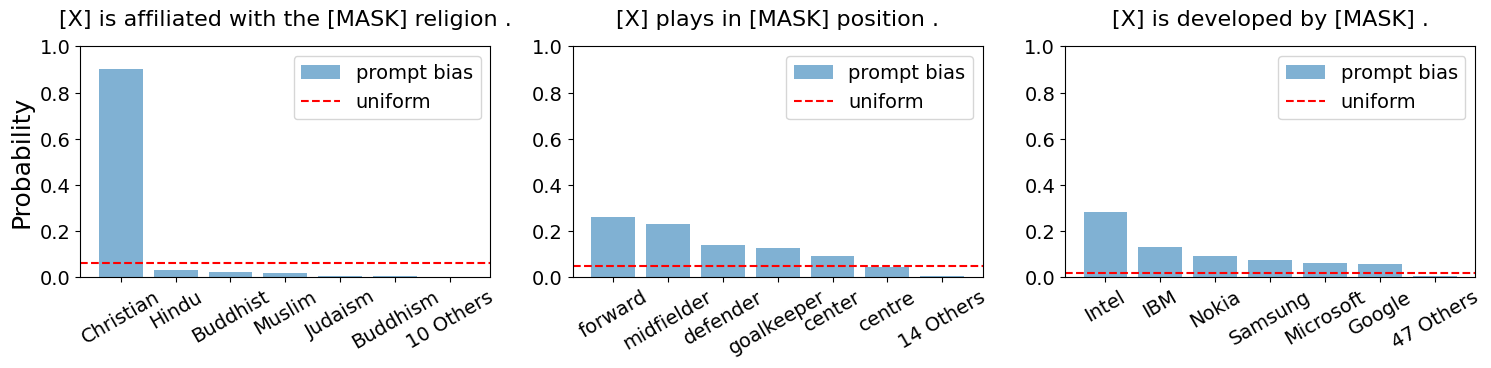

In [22]:
fig, ax = plt.subplots(1,3,figsize=(6*3, 3))  # 增加图表宽度


selected_relations = [
bias_sorted_relation[-20+16],
bias_sorted_relation[-20+1],
 bias_sorted_relation[-20+9],
#  bias_sorted_relation[-20+7], 
 
#  bias_sorted_relation[-20+17], 
 ]

from time import sleep
for i,relation in enumerate(selected_relations):
    print(meta_info_dict[relation])
    title = meta_info_dict[relation].replace("[Y]","[MASK]")
    show_y_label = True if i==0 else False
    observe_prompt_bias(relation, ax[i], y_label=show_y_label, top_num=6, title=title, y_max=1.0)


plt.savefig('prompt_bias_example.pdf', format='pdf', bbox_inches='tight')

[X] is owned by [Y] .
[X] plays in [Y] position .
[X] is represented by music label [Y] .
[X] is produced by [Y] .
[X] is a legal term in [Y] .
[X] was originally aired on [Y] .
[X] is the capital of [Y] .
[X] works for [Y] .
[X] is a [Y] by profession .
[X] is developed by [Y] .
[X] has the position of [Y] .
[X] is a subclass of [Y] .
[X] works in the field of [Y] .
The headquarter of [X] is in [Y] .
[X] consists of [Y] .
[X] shares border with [Y] .
[X] is affiliated with the [Y] religion .
[X] plays [Y] music .
[X] is a member of [Y] .
[X] is part of [Y] .


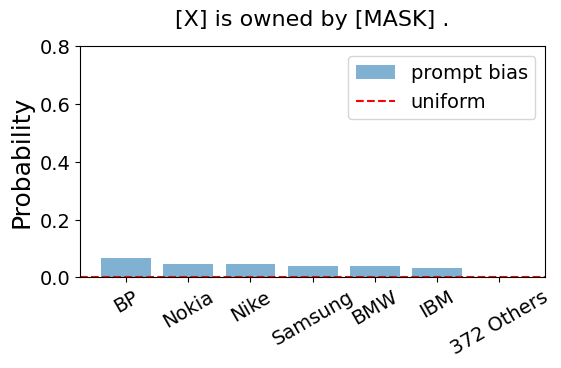

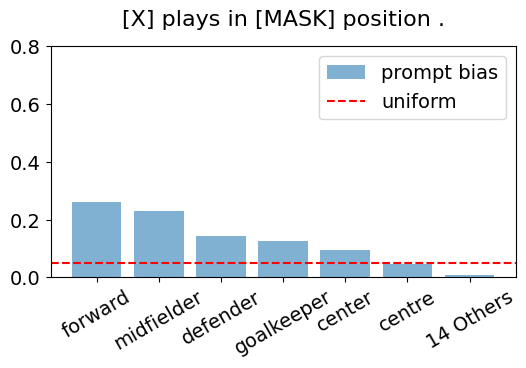

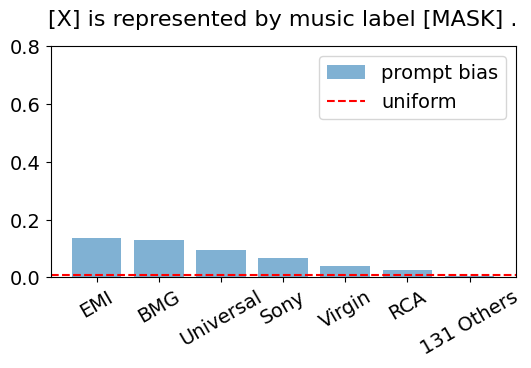

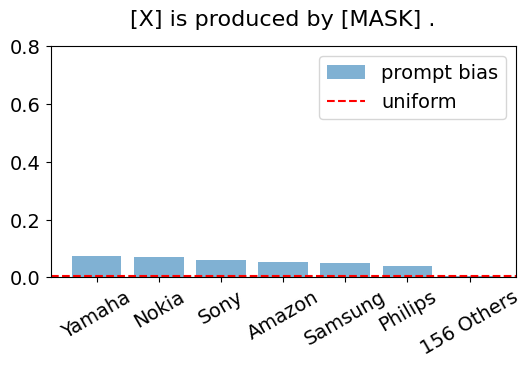

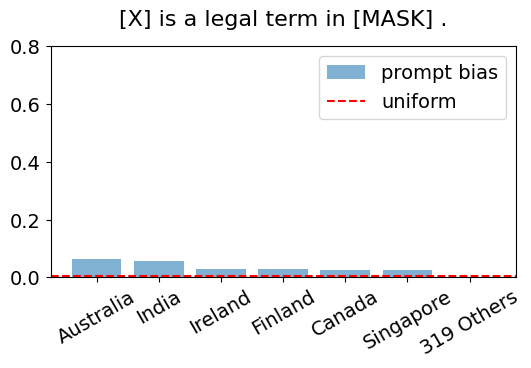

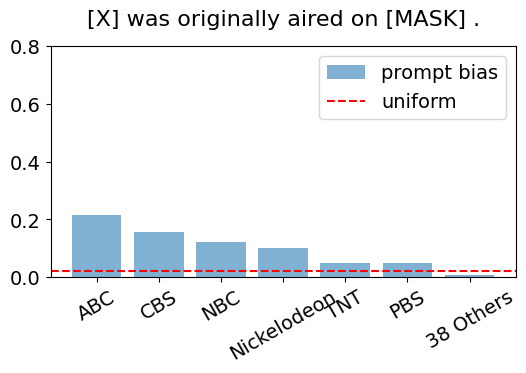

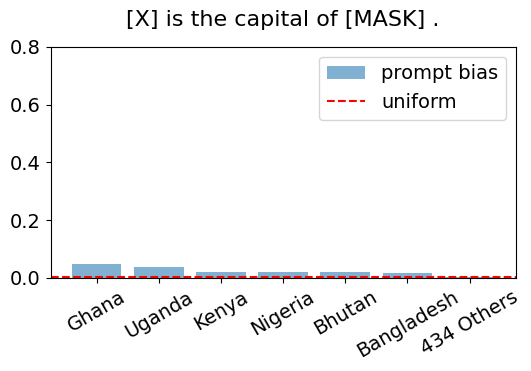

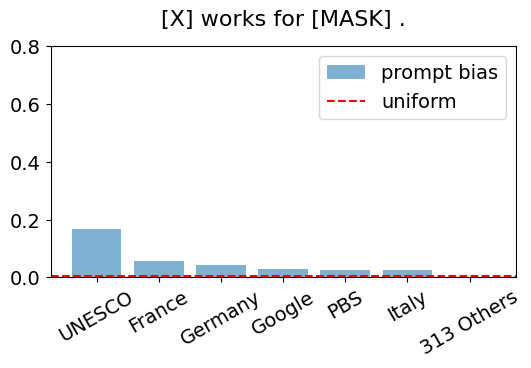

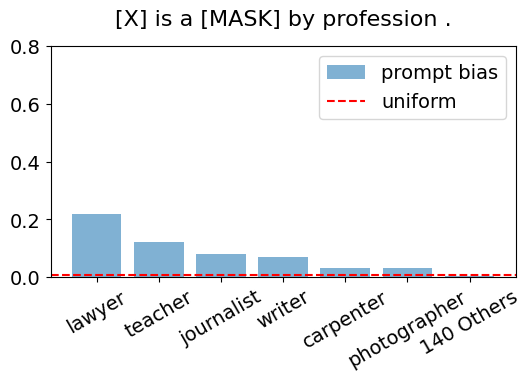

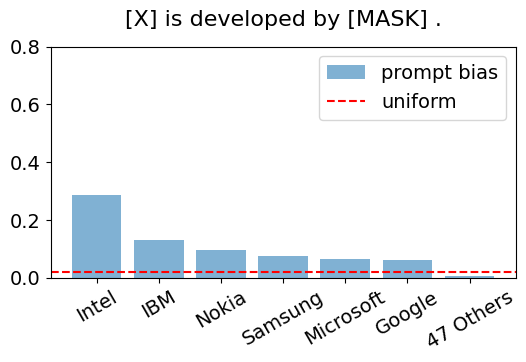

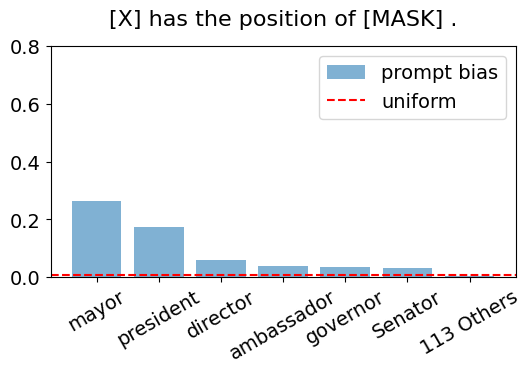

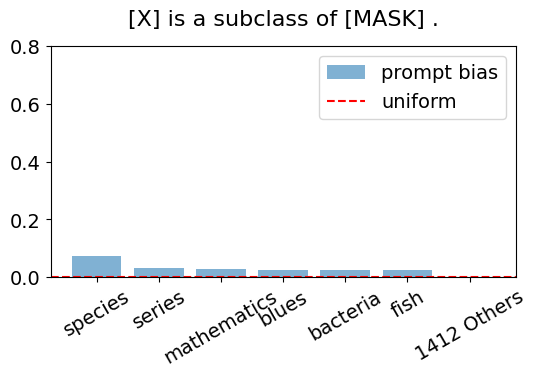

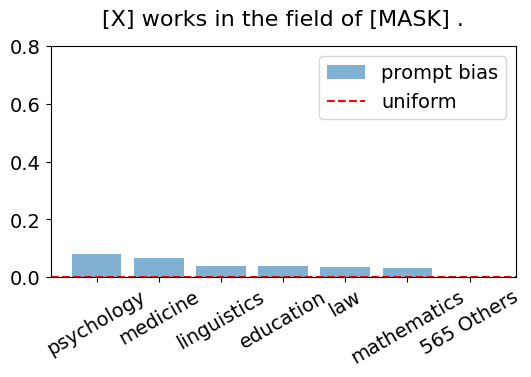

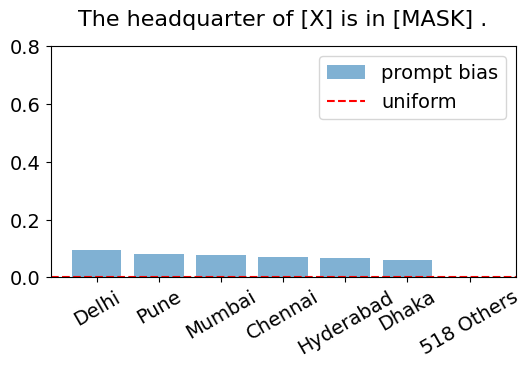

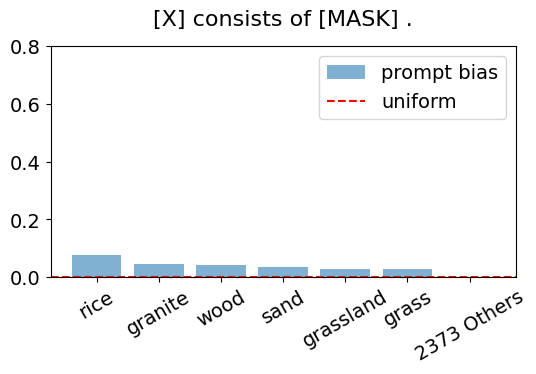

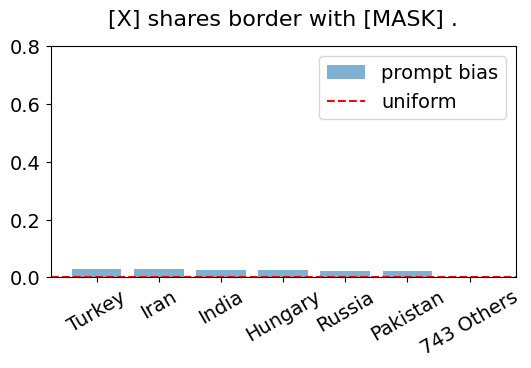

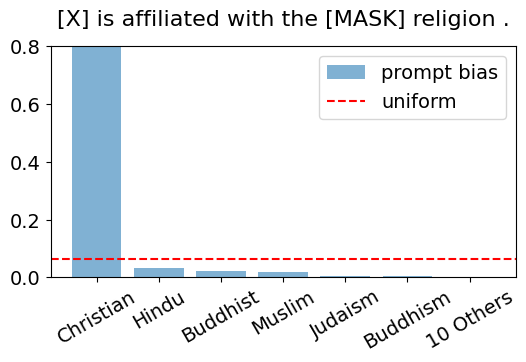

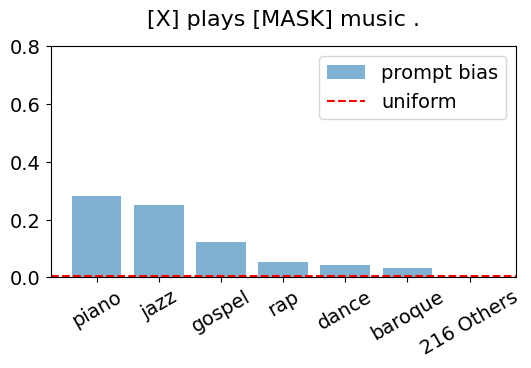

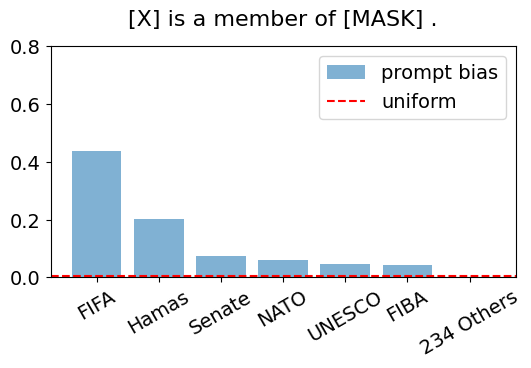

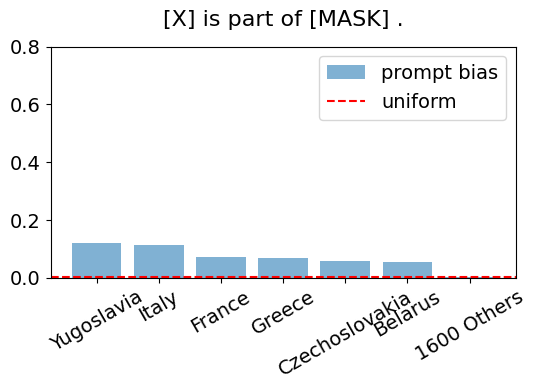

In [12]:
selected_relations = bias_sorted_relation[-20:]
for i,relation in enumerate(selected_relations):
    print(meta_info_dict[relation])
    title = meta_info_dict[relation].replace("[Y]","[MASK]")
    show_y_label = True if i==0 else False
    fig, ax = plt.subplots(1,1,figsize=(6, 3))  # 增加图表宽度
    observe_prompt_bias(relation, ax, y_label=show_y_label, top_num=6, title=title)


### 使用scipy统计js距离

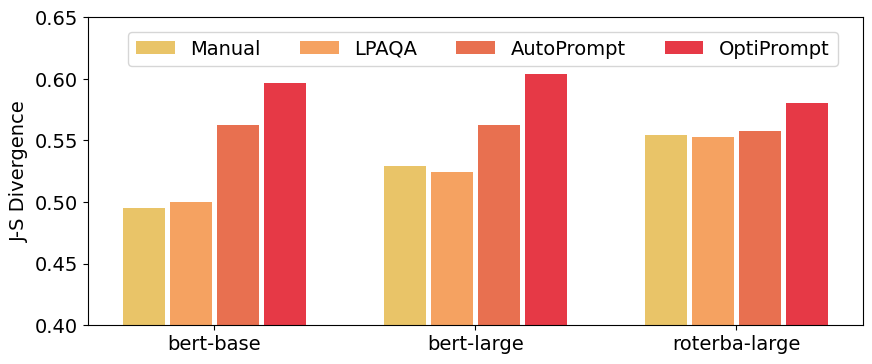

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
models = ['bert-base', 'bert-large', 'roterba-large']
methods = ['Manual', 'LPAQA', 'AutoPrompt', 'OptiPrompt']
data = np.array(quantify_promtp_bias)

# 新颜色
colors = ['#E9C468', '#F5A261', '#E87050', '#E63946']

# 柱状图设置
width = 0.16
pad = 0.02
x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(10, 4))  # 增加图表宽度

for i, method in enumerate(methods):
    ax.bar(x + i * (width+pad), data[:, i], width, label=method, color=colors[i])

# ax.set_xlabel('Models')
ax.set_ylabel('J-S Divergence')
# ax.set_title('Performance Comparison by Method and Model')
ax.set_xticks(x + (width+pad) * (len(methods) - 1) / 2)
ax.set_xticklabels(models)
ax.set_ylim(0.4,0.65)
ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.985), ncol=4)  # 将图例放在图表内部

# 保存为PDF
plt.savefig('quantify_prompt_bias.pdf', format='pdf', bbox_inches='tight')

# 显示图表
plt.show()


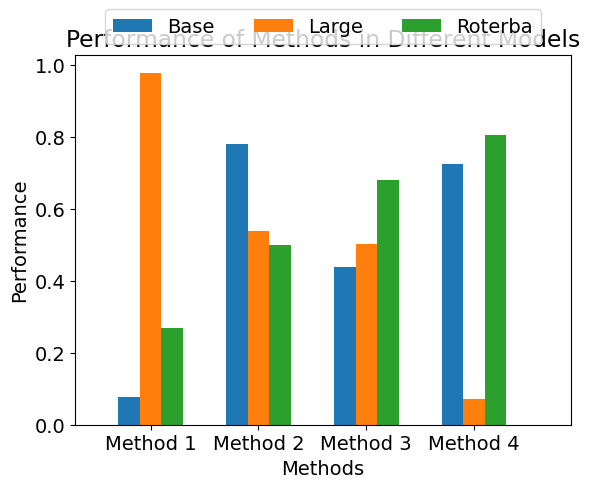

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
methods = ['Method 1', 'Method 2', 'Method 3', 'Method 4']
models = ['Base', 'Large', 'Roterba']
data = {
    'Base': np.random.rand(4),
    'Large': np.random.rand(4),
    'Roterba': np.random.rand(4)
}

# 设置柱状图的宽度
bar_width = 0.2

# 生成x轴刻度
x = np.arange(len(methods))

# 创建三组柱状图
fig, ax = plt.subplots()
for i, model in enumerate(models):
    bars = ax.bar(x + i * bar_width, data[model], bar_width, label=model)

# 设置x轴刻度标签
ax.set_xticks(x + bar_width)
ax.set_xticklabels(methods)

# 添加图例
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)

# 添加标题和标签
ax.set_title('Performance of Methods in Different Models')
ax.set_xlabel('Methods')
ax.set_ylabel('Performance')

# 调整柱子之间的间隔
ax.set_xlim(-0.5, len(methods) - 0.5 + len(models) * bar_width)

# 保存为PDF文件
plt.savefig('bar_chart.pdf', bbox_inches='tight')

# 显示图形
plt.show()
